In [62]:
from scipy.io import wavfile
from scipy.fft import fft
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.pipeline import Pipeline

In [37]:
path = 'voices'
files = os.listdir(path)
fs = 16000
seconds = 3
X_raw = np.zeros((len(files), fs*seconds))
for i, file in enumerate(files):
    X_raw[i, :] = wavfile.read(f"{path}\\{file}")[1]
    y = pd.read_csv('Genders_voices.csv', sep = ';').values

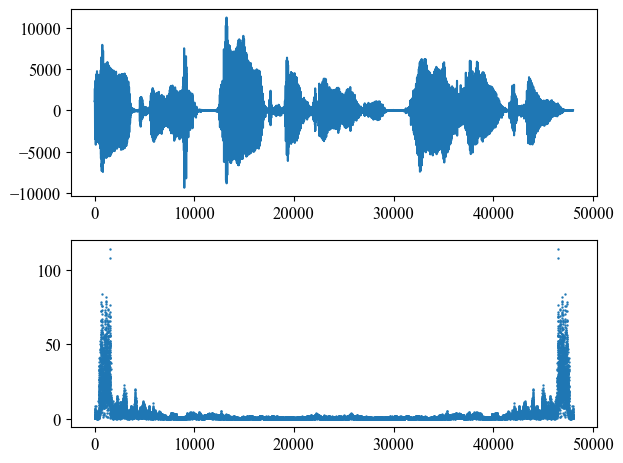

In [38]:
X_fft = np.abs(fft(X_raw, axis = 1)) / X_raw.shape[1]
low_cut = 50 * seconds
high_cut = 280 * seconds
X_fft_cut = X_fft[:, low_cut:high_cut]
fig, ax = plt.subplots(2, 1)
ax[0].plot(np.arange(X_raw.shape[1]), X_raw[0, :])
ax[1].scatter(np.arange(X_raw.shape[1]), X_fft[0, :], s = 0.5)
fig.tight_layout()

In [39]:
mean_num = 3
X_fft = np.reshape(X_fft, (X_fft.shape[0], X_fft.shape[1] // mean_num, mean_num))
X_fft = X_fft.mean(axis=-1)
low_cut = 50
high_cut = 280

X_fft_cut = X_fft[:, low_cut:high_cut]
X_fft_cut = X_fft_cut / np.expand_dims(X_fft_cut.max(axis=1), axis=-1)

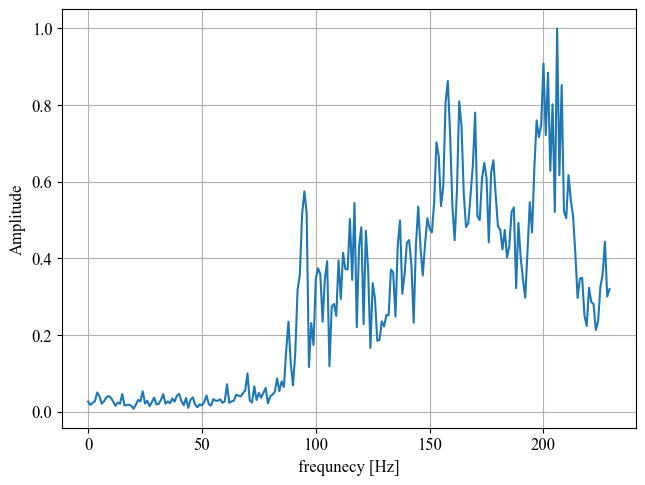

In [40]:
plt.plot(np.arange(X_fft_cut.shape[1]), X_fft_cut[0, :])
plt.grid()
plt.tight_layout()
plt.xlabel('frequnecy [Hz]')
plt.ylabel('Amplitude')
plt.show()

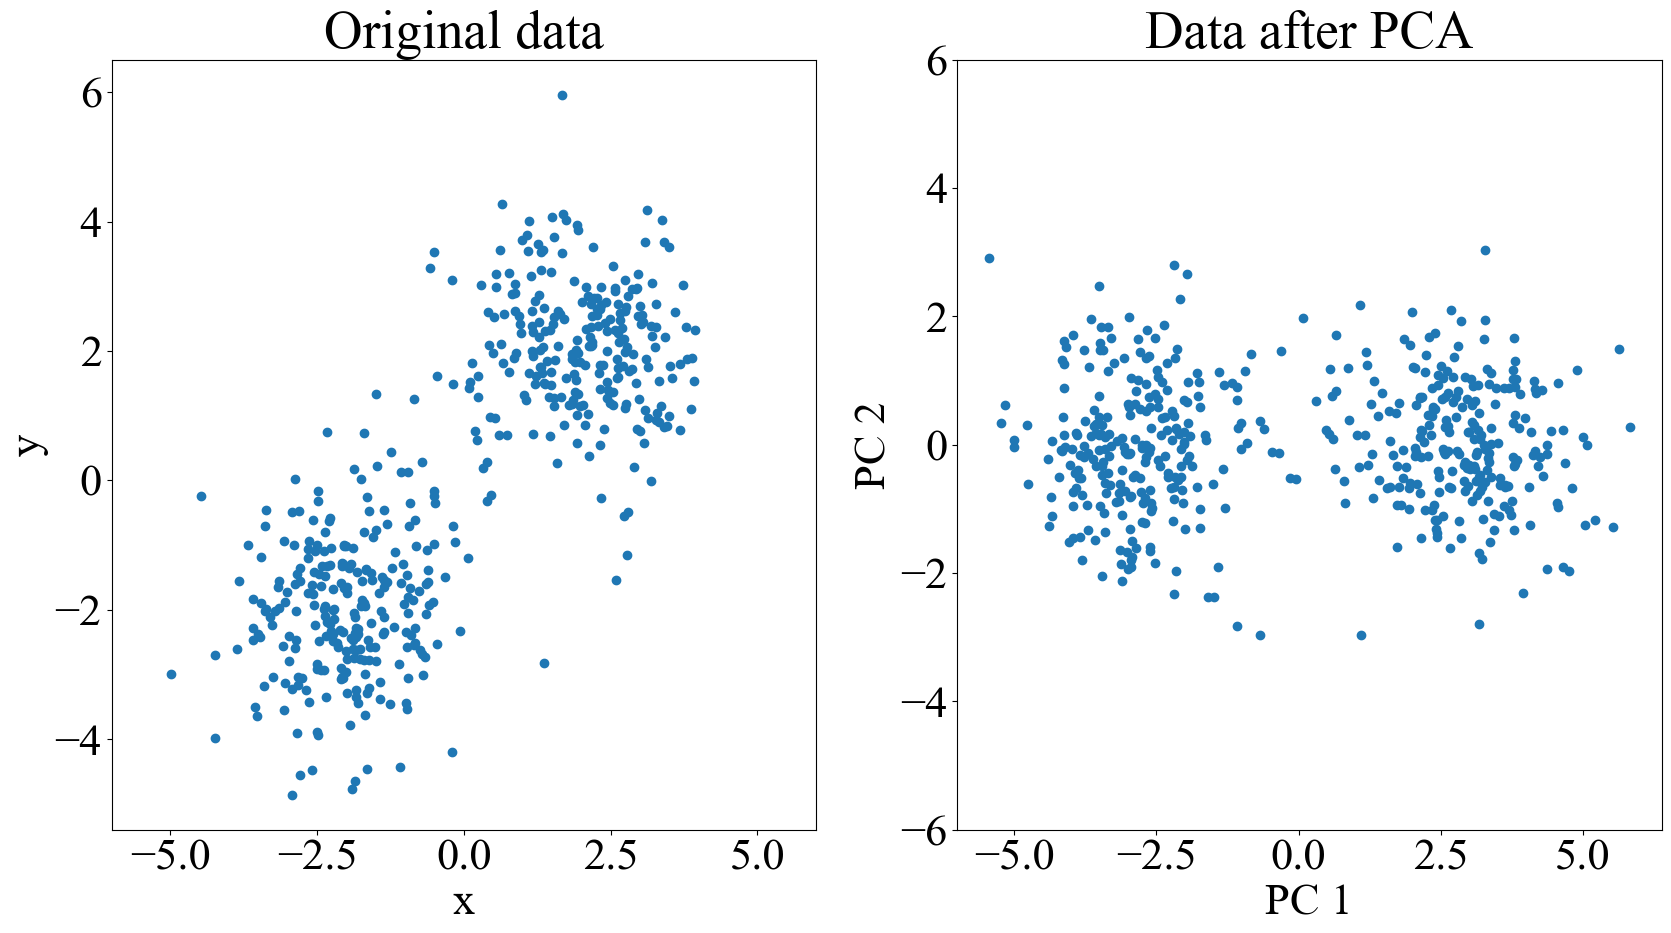

In [41]:
example = np.random.randn(500, 2)
example[:250, :] -= 2
example[250:, :] += 2
example_PCAed = PCA(2).fit_transform(example)
rcParams['font.size'] = 32
rcParams['font.family'] = 'Times New Roman'
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
ax[0].scatter(example[:, 0], example[:, 1])
ax[1].scatter(example_PCAed[:, 0], example_PCAed[:, 1])
lim = 6
ax[0].set_xlim([-lim, lim])
ax[1].set_ylim([-lim, lim])
ax[0].set_xlim([-lim, lim])
ax[1].set_ylim([-lim, lim])
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].set_xlabel('PC 1')
ax[1].set_ylabel('PC 2')
ax[0].set_title('Original data')
ax[1].set_title('Data after PCA')
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_11592\310178753.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column][mask] = 1
C:\Users\Admin\AppData\Local\Temp\ipykernel_11592\310178753.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column][~mask] = 0


9


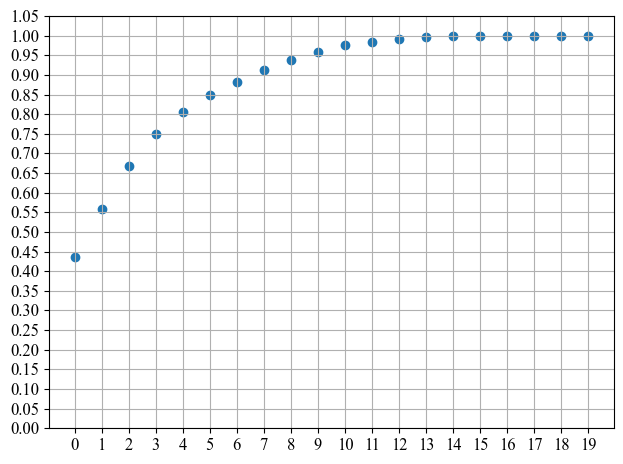

In [42]:
def qualitative_to_0_1(data, column, value_to_be_1):
    mask = data[column].values == value_to_be_1
    data[column][mask] = 1
    data[column][~mask] = 0
    return data

data = pd.read_csv('voice_extracted_features.csv', sep = ',')
data = qualitative_to_0_1(data, 'label', 'female')
features = list(data.columns)
vals = data.values.astype(float)
X = vals[:, :-1]
y = vals[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

pca_transform = PCA()
pca_transform.fit(X_train)

variances = pca_transform.explained_variance_ratio_
cumulated_variances = variances.cumsum()

rcParams['font.size'] = 12
plt.scatter(np.arange(variances.shape[0]), cumulated_variances)
plt.yticks(np.arange(0, 1.1, 0.05))
plt.xticks(np.arange(0, 20, 1))
PC_num = (cumulated_variances < 0.95).sum()
print(PC_num)

plt.tight_layout()
plt.grid()
plt.show()

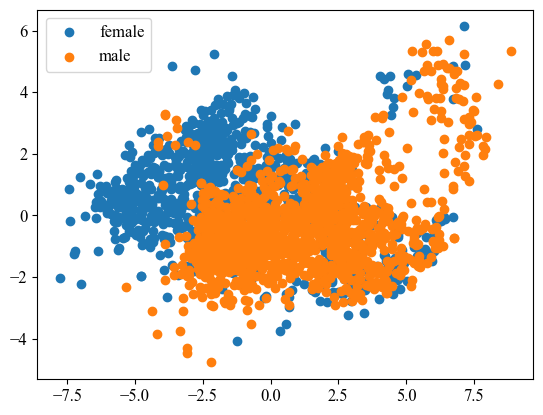

In [43]:
X_pcaed = PCA(2).fit_transform(X_train)
fig, ax = plt.subplots(1, 1)
females = y_train == 1
ax.scatter(X_pcaed[females, 0], X_pcaed[females, 1], label = 'female')
ax.scatter(X_pcaed[~females, 0], X_pcaed[~females, 1], label = 'male')
ax.legend()
plt.show()

In [60]:
# ICA - Independent Component Analysis
X, y = load_digits(return_X_y = True)
transformer = FastICA(n_components = 7, random_state = 0)
X_transformed = transformer.fit_transform(X)

In [61]:
# Pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 6, stratify = y)
pca_transform = PCA(n_components = 9)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_pcaed = pca_transform.fit_transform(X_train)
X_test_pcaed = pca_transform.transform(X_test)
X_train_pcaed_scaled = scaler.fit_transform(X_train_pcaed)
X_test_pcaed_scaled = scaler.transform(X_test_pcaed)
model = kNN(5, weights = 'distance')
model.fit(X_train_pcaed_scaled, y_train)
y_predict = model.predict(X_test_pcaed_scaled)

In [63]:
pipe = Pipeline([['transformer', PCA(9)], 
                 ['scaler', StandardScaler()],
                 ['classifier', kNN(weights = 'distance')]])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)